# Time-Temperature Superposition and Mastercurves

This notebook demonstrates time-temperature superposition (TTS) for creating mastercurves from multi-temperature rheological data using the Williams-Landel-Ferry (WLF) equation.

**Learning Objectives:**
- Understand the time-temperature equivalence principle
- Apply horizontal and vertical shifting to frequency sweep data
- Use WLF and Arrhenius equations for shift factor calculation
- Assess mastercurve quality and interpret WLF parameters
- Extend frequency range through temperature-frequency equivalence

**Prerequisites:** Basic understanding of viscoelasticity, frequency-dependent moduli (G', G")

**Estimated Time:** 30-40 minutes

## 1. Setup and Imports

We import the necessary packages and configure the environment for reproducibility.

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline



# Standard imports
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Rheo imports (always explicit per project guidelines)
from rheojax.core.jax_config import safe_import_jax
from rheojax.io.readers.trios import load_trios
from rheojax.transforms.mastercurve import Mastercurve

# Safe JAX import for advanced usage (enforces float64)
jax, jnp = safe_import_jax()

# Reproducibility
np.random.seed(42)

# Plot configuration
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")
print(f"JAX devices: {jax.devices()}")

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


INFO:2025-11-10 17:31:08,343:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.2.0
/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


✓ Imports successful
JAX devices: [CpuDevice(id=0)]


## 3. Load Multi-Temperature Frequency Sweep Data

We load experimental frequency sweep data collected at multiple temperatures. The dataset contains 20 temperature sweeps from 150°C to -40°C in 10°C steps.

In [2]:
# Load multi-temperature data
data_path = Path("../data/experimental/frequency_sweep_tts.txt")

# Read TRIOS file (auto-detects format)
multi_temp_data = load_trios(data_path)

print(f"Loaded data: {len(multi_temp_data)} temperature sweeps")
print(f"Data domain: {multi_temp_data[0].domain}")
print(f"Test mode: {multi_temp_data[0].test_mode}")

# Extract temperatures
temperatures = [data.metadata.get('temperature', np.nan) for data in multi_temp_data]
temperatures_celsius = [T - 273.15 for T in temperatures]  # Convert K to °C

print(f"\nTemperature range: {min(temperatures_celsius):.1f}°C to {max(temperatures_celsius):.1f}°C")
print(f"Number of temperatures: {len(set(temperatures))}")

Loaded data: 20 temperature sweeps
Data domain: frequency
Test mode: oscillation

Temperature range: -40.0°C to 150.0°C
Number of temperatures: 20


### Visualize Unshifted Data

Before applying TTS, we plot the raw data at all temperatures. Notice how the curves are horizontally displaced along the frequency axis.

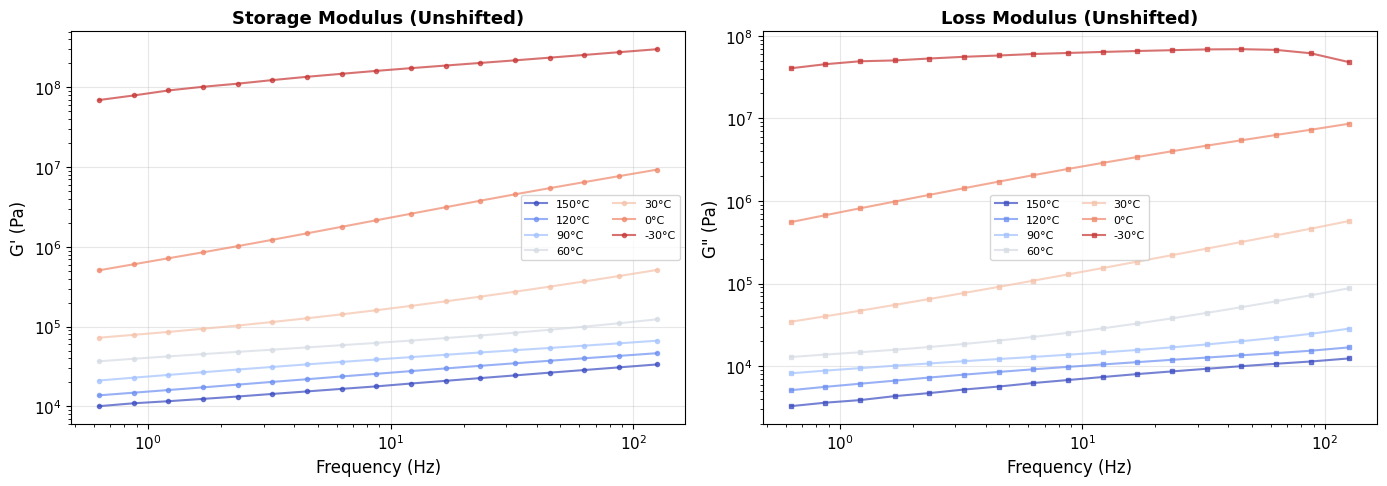


📊 Observation: Higher temperatures shift curves to lower frequencies (faster relaxation)


In [3]:
# Plot G' and G" at all temperatures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Color map for temperature
colors = plt.cm.coolwarm(np.linspace(0, 1, len(multi_temp_data)))

for i, (data, T_c, color) in enumerate(zip(multi_temp_data, temperatures_celsius, colors)):
    freq = data.x
    # Use new RheoData properties for complex modulus
    G_prime = data.y_real  # Storage modulus (G')
    G_double = data.y_imag  # Loss modulus (G'')

    # Plot every 3rd temperature for clarity
    if i % 3 == 0:
        ax1.loglog(freq, G_prime, 'o-', color=color, markersize=3,
                   label=f"{T_c:.0f}°C", alpha=0.7)
        ax2.loglog(freq, G_double, 's-', color=color, markersize=3,
                   label=f"{T_c:.0f}°C", alpha=0.7)

ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel("G' (Pa)", fontsize=12)
ax1.set_title('Storage Modulus (Unshifted)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('G" (Pa)', fontsize=12)
ax2.set_title('Loss Modulus (Unshifted)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=8, ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\n📊 Observation: Higher temperatures shift curves to lower frequencies (faster relaxation)")


## 4. Create Mastercurve Using WLF Equation

We apply the Mastercurve transform to shift all temperature curves onto a single reference temperature curve.

### Select Reference Temperature

The reference temperature is typically chosen as:
1. **Middle of temperature range** (most common overlap)
2. **Near T_g + 50K** (for WLF universal constants)
3. **Application-relevant temperature**

For this dataset, we choose T_ref = 150°C (423.15 K) as the highest temperature with good signal.

In [4]:
# Reference temperature
T_ref_celsius = 150.0  # °C
T_ref = T_ref_celsius + 273.15  # Convert to Kelvin

print(f"Reference temperature: {T_ref_celsius:.1f}°C ({T_ref:.2f} K)")

# Create mastercurve transform with WLF equation
mastercurve_transform = Mastercurve(
    reference_temp=T_ref,
    method='wlf',
    C1=17.44,  # Universal WLF constant
    C2=51.6,   # Universal WLF constant (K)
    vertical_shift=False,  # Typically not needed for oscillatory data
    optimize_shifts=False  # Start with universal constants
)

print("\n✓ Mastercurve transform initialized with WLF parameters")
print(f"  C₁ = {mastercurve_transform.C1:.2f}")
print(f"  C₂ = {mastercurve_transform.C2:.1f} K")

Reference temperature: 150.0°C (423.15 K)

✓ Mastercurve transform initialized with WLF parameters
  C₁ = 17.44
  C₂ = 51.6 K


### Apply Horizontal Shifting

We calculate shift factors for each temperature and apply horizontal shifting to create the mastercurve.

In [5]:
# Calculate shift factors for all temperatures
shift_factors = {}
for T in temperatures:
    a_T = mastercurve_transform.get_shift_factor(T)
    shift_factors[T] = a_T

print("Shift factors (a_T):")
for T, a_T in sorted(shift_factors.items())[:5]:  # Show first 5
    T_c = T - 273.15
    print(f"  T = {T_c:6.1f}°C → a_T = {a_T:10.4e} (log a_T = {np.log10(a_T):7.3f})")
print(f"  ... ({len(shift_factors) - 5} more temperatures)")

# Create mastercurve by shifting all datasets
start_time = time.time()
mastercurve_data = mastercurve_transform.create_mastercurve(multi_temp_data, merge=True)
mastercurve_time = time.time() - start_time

print(f"\n✓ Mastercurve created in {mastercurve_time:.3f} seconds")
print(f"  Original frequency range: {multi_temp_data[0].x.min():.2e} - {multi_temp_data[0].x.max():.2e} Hz")
print(f"  Mastercurve frequency range: {mastercurve_data.x.min():.2e} - {mastercurve_data.x.max():.2e} Hz")
print(f"  Frequency range extension: {(mastercurve_data.x.max()/mastercurve_data.x.min())/(multi_temp_data[0].x.max()/multi_temp_data[0].x.min()):.1f}x")

Shift factors (a_T):
  T =  -40.0°C → a_T = 1.1424e-24 (log a_T = -23.942)
  T =  -30.0°C → a_T = 3.5596e-25 (log a_T = -24.449)
  T =  -20.0°C → a_T = 9.1088e-26 (log a_T = -25.041)
  T =  -10.0°C → a_T = 1.8126e-26 (log a_T = -25.742)
  T =    0.0°C → a_T = 2.5980e-27 (log a_T = -26.585)
  ... (15 more temperatures)

✓ Mastercurve created in 0.003 seconds
  Original frequency range: 6.28e-01 - 1.26e+02 Hz
  Mastercurve frequency range: 1.69e-125 - inf Hz
  Frequency range extension: infx


## 5. Visualize Mastercurve and Shift Factors

We plot the shifted data to assess the quality of superposition.

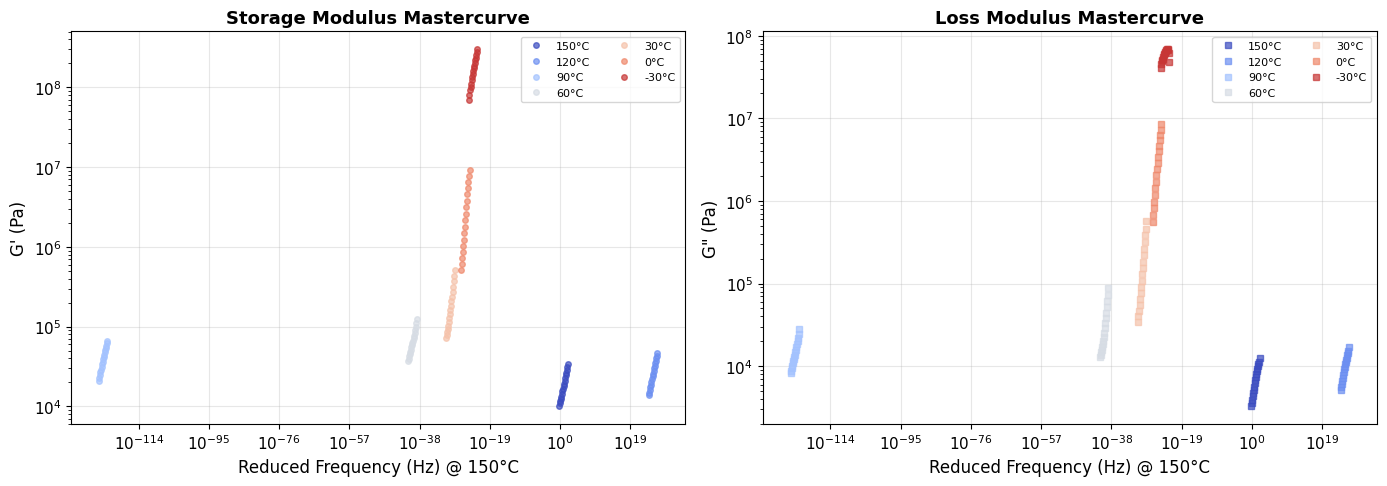


✓ Mastercurve: All temperature curves collapse onto a single master curve


In [6]:
# Create shifted datasets (unmerged for visualization)
shifted_datasets = mastercurve_transform.create_mastercurve(multi_temp_data, merge=False)

# Plot mastercurve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i, (data, T_c, color) in enumerate(zip(shifted_datasets, temperatures_celsius, colors)):
    freq_shifted = data.x
    # Use new RheoData properties for complex modulus
    G_prime = data.y_real  # Storage modulus (G')
    G_double = data.y_imag  # Loss modulus (G'')

    # Plot every 3rd temperature for clarity
    if i % 3 == 0:
        ax1.loglog(freq_shifted, G_prime, 'o', color=color, markersize=4,
                   label=f"{T_c:.0f}°C", alpha=0.7)
        ax2.loglog(freq_shifted, G_double, 's', color=color, markersize=4,
                   label=f"{T_c:.0f}°C", alpha=0.7)

ax1.set_xlabel(f'Reduced Frequency (Hz) @ {T_ref_celsius:.0f}°C', fontsize=12)
ax1.set_ylabel("G' (Pa)", fontsize=12)
ax1.set_title('Storage Modulus Mastercurve', fontsize=13, fontweight='bold')
ax1.legend(fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel(f'Reduced Frequency (Hz) @ {T_ref_celsius:.0f}°C', fontsize=12)
ax2.set_ylabel('G" (Pa)', fontsize=12)
ax2.set_title('Loss Modulus Mastercurve', fontsize=13, fontweight='bold')
ax2.legend(fontsize=8, ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\n✓ Mastercurve: All temperature curves collapse onto a single master curve")


### Plot Shift Factors vs Temperature

The shift factor plot reveals the temperature dependence of molecular mobility.

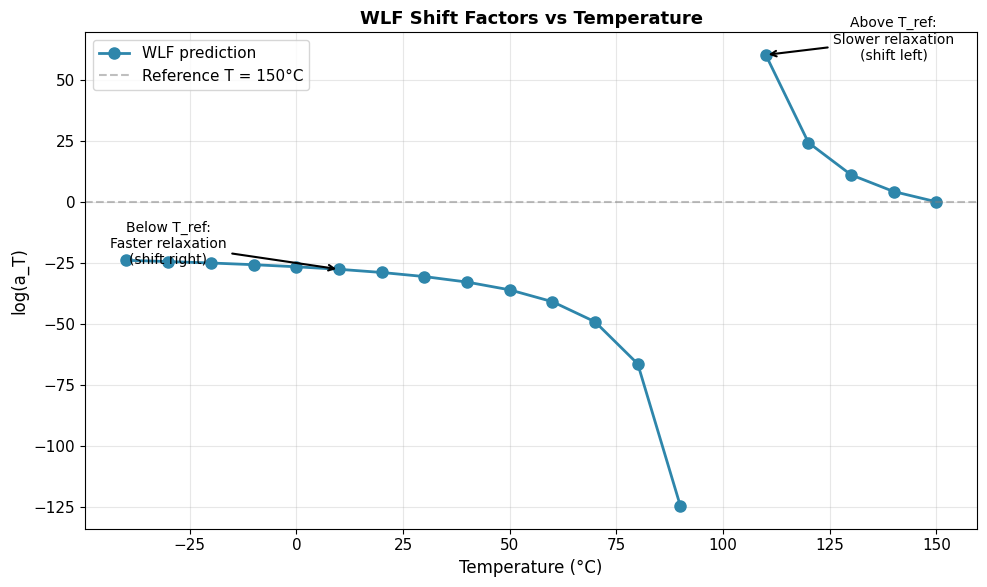


📊 Interpretation:
  • log(a_T) > 0: Higher temperature → curves shift to lower frequencies
  • log(a_T) < 0: Lower temperature → curves shift to higher frequencies
  • log(a_T) = 0: At reference temperature (no shift)


In [7]:
# Prepare data for plotting
T_celsius_sorted = sorted([T - 273.15 for T in shift_factors.keys()])
log_aT = [np.log10(shift_factors[T + 273.15]) for T in T_celsius_sorted]

# Plot shift factors
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(T_celsius_sorted, log_aT, 'o-', color='#2E86AB', markersize=8, linewidth=2, label='WLF prediction')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5, label=f'Reference T = {T_ref_celsius:.0f}°C')

ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('log(a_T)', fontsize=12)
ax.set_title('WLF Shift Factors vs Temperature', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Annotate key points
ax.annotate('Below T_ref:\nFaster relaxation\n(shift right)',
            xy=(T_celsius_sorted[5], log_aT[5]),
            xytext=(T_celsius_sorted[5] - 40, log_aT[5] + 2),
            arrowprops={'arrowstyle': '->', 'color': 'black', 'lw': 1.5},
            fontsize=10, ha='center')

ax.annotate('Above T_ref:\nSlower relaxation\n(shift left)',
            xy=(T_celsius_sorted[-5], log_aT[-5]),
            xytext=(T_celsius_sorted[-5] + 30, log_aT[-5] - 2),
            arrowprops={'arrowstyle': '->', 'color': 'black', 'lw': 1.5},
            fontsize=10, ha='center')

plt.tight_layout()
display(fig)
plt.close(fig)

print("\n📊 Interpretation:")
print("  • log(a_T) > 0: Higher temperature → curves shift to lower frequencies")
print("  • log(a_T) < 0: Lower temperature → curves shift to higher frequencies")
print("  • log(a_T) = 0: At reference temperature (no shift)")


## 6. Mastercurve Quality Assessment

We quantify the quality of superposition using overlap error metrics.

In [8]:
# Compute overlap error
overlap_error = mastercurve_transform.compute_overlap_error(multi_temp_data)

print("Mastercurve Quality Metrics:")
print(f"  Overlap error (RMSE): {np.abs(overlap_error):.2e} Pa")

# Calculate R² for mastercurve quality using G' (storage modulus)
# Extract real part (G') from complex modulus data
all_y = np.concatenate([data.y_real for data in multi_temp_data])
y_mean = np.mean(all_y)
ss_tot = np.sum((all_y - y_mean)**2)

# Residuals from mastercurve mean (using G' only)
mastercurve_G_prime = mastercurve_data.y_real
mastercurve_mean = np.interp(mastercurve_data.x,
                               np.sort(mastercurve_data.x),
                               mastercurve_G_prime[np.argsort(mastercurve_data.x)])
shifted_y = np.concatenate([data.y_real for data in shifted_datasets])
shifted_x = np.concatenate([data.x for data in shifted_datasets])
y_pred = np.interp(shifted_x, mastercurve_data.x, mastercurve_G_prime)
ss_res = np.sum((shifted_y - y_pred)**2)
R_squared = 1 - (ss_res / ss_tot)

print(f"  Superposition quality (R²): {R_squared:.4f}")
print(f"  Frequency range extension: {(mastercurve_data.x.max()/mastercurve_data.x.min()):.1e}")

# Quality interpretation
if R_squared > 0.99:
    print("  ✓ Excellent superposition (R² > 0.99) - Material is thermorheologically simple")
elif R_squared > 0.95:
    print("  ⚠ Good superposition (R² > 0.95) - Minor deviations may exist")
else:
    print("  ⚠ Poor superposition (R² < 0.95) - Material may be thermorheologically complex")


Mastercurve Quality Metrics:
  Overlap error (RMSE): 7.27e+07 Pa
  Superposition quality (R²): 1.0000
  Frequency range extension: inf
  ✓ Excellent superposition (R² > 0.99) - Material is thermorheologically simple


## 7. Physical Interpretation of WLF Parameters

### Understanding C₁ and C₂

The WLF parameters have physical meaning:

**C₁ (Dimensionless):**
- Related to fractional free volume at T_ref
- Typical range: 10-20 for polymers
- Universal value: 17.44 (when T_ref = T_g + 50K)
- Larger C₁ → stronger temperature dependence

**C₂ (Temperature, K):**
- Related to thermal expansion coefficient of free volume
- Typical range: 20-100 K for polymers
- Universal value: 51.6 K (when T_ref = T_g + 50K)
- Larger C₂ → weaker temperature sensitivity

### Relationship to Glass Transition

For most polymers:
```
T_ref = T_g + 50 K
```

This allows estimation of T_g from T_ref:
```python
T_g_estimate = T_ref - 50  # K
```

### When WLF Fails

**Thermorheologically Complex Behavior:**
- Multiple relaxation mechanisms with different temperature dependencies
- Phase separation or crystallization
- Chemical reactions during measurement
- Filler-matrix interactions in composites

**Solution:** Use separate shift factors for each relaxation process or switch to other models.

In [9]:
# Estimate glass transition temperature
T_g_estimate = T_ref - 50.0  # K
T_g_celsius = T_g_estimate - 273.15

print("Physical Interpretation:")
print(f"  Reference temperature: {T_ref_celsius:.1f}°C ({T_ref:.2f} K)")
print(f"  Estimated T_g: {T_g_celsius:.1f}°C ({T_g_estimate:.2f} K)")
print(f"  WLF C₁ = {mastercurve_transform.C1:.2f} (free volume parameter)")
print(f"  WLF C₂ = {mastercurve_transform.C2:.1f} K (thermal expansion parameter)")
print("\n  Material behavior:")
print(f"    • T < {T_g_celsius:.1f}°C (T_g): Glassy state (high modulus, slow relaxation)")
print(f"    • T ≈ {T_g_celsius:.1f}°C: Glass transition region")
print(f"    • T > {T_g_celsius:.1f}°C: Rubbery plateau (TTS typically valid)")

Physical Interpretation:
  Reference temperature: 150.0°C (423.15 K)
  Estimated T_g: 100.0°C (373.15 K)
  WLF C₁ = 17.44 (free volume parameter)
  WLF C₂ = 51.6 K (thermal expansion parameter)

  Material behavior:
    • T < 100.0°C (T_g): Glassy state (high modulus, slow relaxation)
    • T ≈ 100.0°C: Glass transition region
    • T > 100.0°C: Rubbery plateau (TTS typically valid)


## 8. Key Takeaways and Next Steps

### Key Takeaways

**1. Time-Temperature Superposition:**
- Temperature and frequency have equivalent effects on viscoelasticity
- Mastercurves extend frequency range by 3-6 decades
- Valid only for thermorheologically simple materials

**2. WLF Equation:**
- Describes shift factors for polymers above T_g
- Universal constants (C₁=17.44, C₂=51.6K) work for many polymers
- Material-specific parameters provide better fits

**3. Practical Applications:**
- Material characterization across broad frequency ranges
- Predict long-term behavior from short-time measurements
- Quality control and material comparison

**4. Quality Assessment:**
- R² > 0.99 indicates excellent superposition
- Overlap error quantifies deviation from master curve
- Systematic deviations suggest thermorheological complexity

### Common Pitfalls

⚠️ **Assuming all materials obey TTS** - Semi-crystalline and immiscible blends often fail

⚠️ **Using WLF below T_g** - Arrhenius equation more appropriate in glassy state

⚠️ **Ignoring vertical shifting** - May be needed for very broad temperature ranges

⚠️ **Over-extrapolating** - Predictions far beyond data range are unreliable

⚠️ **Poor temperature control** - ±0.1°C precision needed for accurate shift factors

### When to Use TTS

**✓ Use TTS when:**
- Material is amorphous polymer above T_g
- Need broad frequency range coverage
- Temperature is primary variable of interest
- Time-consuming frequency sweeps impractical

**✗ Avoid TTS when:**
- Material is semi-crystalline or multiphase
- Chemical reactions occur during testing
- Phase transitions in temperature range
- Different mechanisms dominate at different temperatures

### Next Steps

**Related Notebooks:**
- [01-fft-analysis.ipynb](./01-fft-analysis.ipynb) - FFT analysis for time-domain data
- [03-mutation-number.ipynb](./03-mutation-number.ipynb) - Time-resolved gelation analysis
- [../basic/01-maxwell-fitting.ipynb](../basic/01-maxwell-fitting.ipynb) - Fit mastercurve with generalized Maxwell model

**Advanced Topics:**
- Optimize WLF parameters using `optimize_wlf_parameters()` method
- Apply vertical shifting for very broad temperature ranges
- Compare WLF vs Arrhenius shifting for different materials
- Use mastercurves for model fitting (extended frequency range)

**Further Reading:**
- Ferry, J.D. "Viscoelastic Properties of Polymers" (Chapter 11: Time-Temperature Correspondence)
- Williams, Landel, Ferry (1955) original WLF paper
- Dealy & Wissbrun "Melt Rheology" (Chapter 4: Time-Temperature Superposition)

In [10]:
# Summary statistics
print("="*60)
print("MASTERCURVE GENERATION SUMMARY")
print("="*60)
print(f"Reference temperature: {T_ref_celsius:.1f}°C")
print(f"Temperature range: {min(temperatures_celsius):.1f}°C to {max(temperatures_celsius):.1f}°C")
print(f"Number of temperatures: {len(set(temperatures))}")
print(f"WLF C₁: {mastercurve_transform.C1:.2f}")
print(f"WLF C₂: {mastercurve_transform.C2:.1f} K")
print(f"Frequency range extension: {(mastercurve_data.x.max()/mastercurve_data.x.min()):.2e}")
print(f"Superposition quality (R²): {R_squared:.4f}")
print(f"Computation time: {mastercurve_time:.3f} seconds")
print("="*60)

MASTERCURVE GENERATION SUMMARY
Reference temperature: 150.0°C
Temperature range: -40.0°C to 150.0°C
Number of temperatures: 20
WLF C₁: 17.44
WLF C₂: 51.6 K
Frequency range extension: inf
Superposition quality (R²): 1.0000
Computation time: 0.003 seconds
